In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite, aw_psi_hermite_complement
from operators.mixed_method_0.setup_mixed_method_0_two_stream import SimulationSetupMixedMethod0
from operators.adaptive_aw_hermite import updated_u, updated_alpha
from operators.poisson_solver import gmres_solver
from operators.aw_hermite.aw_hermite_operators import total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre
from operators.aw_hermite.aw_hermite_operators import nonlinear_aw_hermite, charge_density_two_stream_aw_hermite

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Mixed method #0 two-stream (with $u(x, t)$ and $\alpha(x, t)$)

In [4]:
setup = SimulationSetupMixedMethod0(Nx=51,
                                    Nv_e1=50,
                                    Nv_e2=50,
                                    epsilon=1e-3,
                                    alpha_e1=1/2,
                                    alpha_i=np.sqrt(2 / 1836),
                                    u_e1=-1,
                                    u_e2=1,
                                    alpha_e2=1/2,
                                    L=2*np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=43,
                                    k0=1,
                                    nu_H=2,
                                    gamma=0.,
                                    u_tol=0.01,
                                    alpha_tol=0.5,
                                    n0_e1=0.5,
                                    n0_e2=0.5,
                                    adaptive_in_space=True,
                                    construct_integrals=False)

In [5]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx)

In [6]:
# spatial grid 
x_ = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(-4, 4, 1000, endpoint=True)

# simulation results

In [7]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/sol_u_NvH_" + str(setup.Nv_e1) 
                         + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/sol_t_NvH_" + str(setup.Nv_e1) 
                         + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(5100, 4301)
(4301,)


In [8]:
runtime = np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/sol_runtime_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([1456.175597  ,  379.83938408])

In [9]:
alpha_e1=np.array(np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/alpha_e1_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy"))

u_e1=np.array(np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/u_e1_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy"))

alpha_e2=np.array(np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/alpha_e2_Nve2_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy"))

u_e2=np.array(np.load("../../data/mixed_method_0_aw_hermite_aw_hermite/two_stream/u_e2_Nve2_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy"))

In [10]:
change_idxs_alpha_e1 = np.where(np.diff(alpha_e1, axis=0) != 0)[0]
change_idxs_u_e1 = np.where(np.diff(u_e1, axis=0) != 0)[0]

change_idxs_alpha_e2 = np.where(np.diff(alpha_e2, axis=0) != 0)[0]
change_idxs_u_e2 = np.where(np.diff(u_e2, axis=0) != 0)[0]

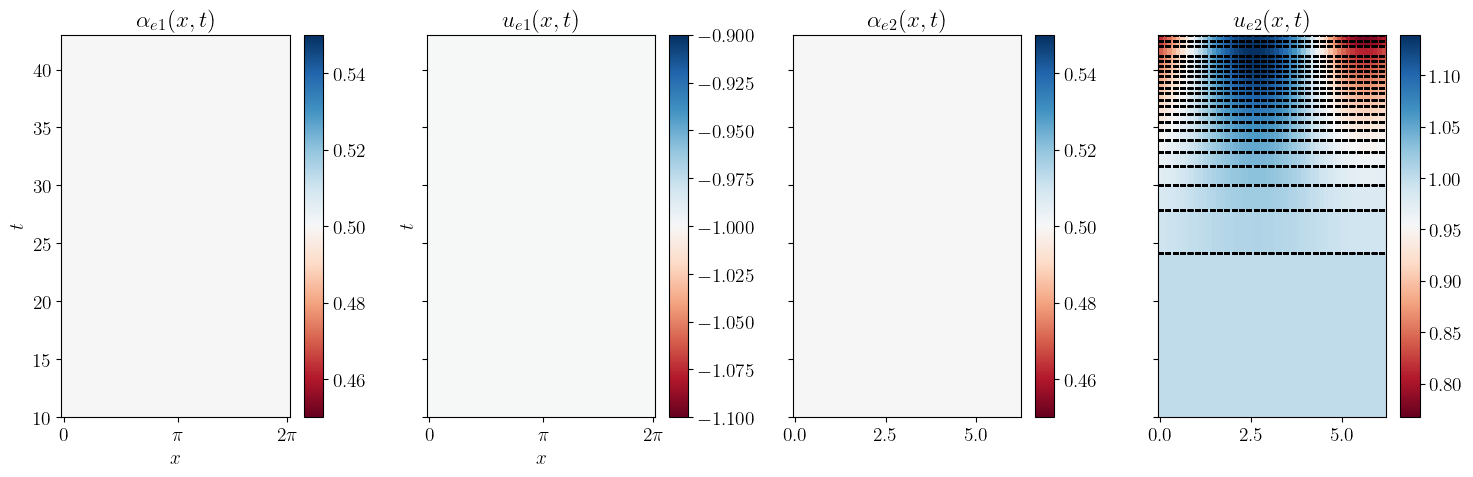

In [11]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(15, 5))
pos = ax[0].pcolormesh(x_[:-1], sol_midpoint_t, alpha_e1, cmap="RdBu")
cbar = fig.colorbar(pos)
pos = ax[1].pcolormesh(x_[:-1], sol_midpoint_t, u_e1, cmap="RdBu")
cbar = fig.colorbar(pos)
pos = ax[2].pcolormesh(x_[:-1], sol_midpoint_t, alpha_e2, cmap="RdBu")
cbar = fig.colorbar(pos)
pos = ax[3].pcolormesh(x_[:-1], sol_midpoint_t, u_e2, cmap="RdBu")
cbar = fig.colorbar(pos)

ax[0].set_title(r"$\alpha_{e1}(x, t)$")
ax[1].set_title(r"$u_{e1}(x, t)$")
ax[2].set_title(r"$\alpha_{e2}(x, t)$")
ax[3].set_title(r"$u_{e2}(x, t)$")
ax[0].set_xlabel(r"$x$")
ax[1].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$t$")
ax[1].set_ylabel(r"$t$")
ax[0].set_xticks([0, np.pi, 2*np.pi-setup.dx])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_xticks([0, np.pi, 2*np.pi-setup.dx])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2 \pi$"])
for ii in range(len(change_idxs_u_e1)):
    ax[1].axhline(sol_midpoint_t[change_idxs_u_e1[ii]], color="black", ls="--", linewidth=1)
for ii in range(len(change_idxs_u_e2)):
    ax[3].axhline(sol_midpoint_t[change_idxs_u_e2[ii]], color="black", ls="--", linewidth=1)
ax[1].set_ylim(10, sol_midpoint_t[-1])
plt.tight_layout()

In [12]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [13]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_e1,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_e2,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii], (setup.Nv_e1, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_e1*setup.Nx:, ii], (setup.Nv_e2, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream_aw_hermite(C0_e1=sol_midpoint_u[:setup.Nx, ii],
                                               C0_e2=sol_midpoint_u[setup.Nx * setup.Nv_e1: setup.Nx * (setup.Nv_e1 + 1), ii],
                                               C0_i=np.ones(setup.Nx) / setup.alpha_i[-1],
                                               alpha_e1=alpha_e1[ii, :],
                                               alpha_e2=alpha_e2[ii, :],
                                               alpha_i=setup.alpha_i[-1])

    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_49413/3935866562.py:23: RuntimeWarning: divide by zero encountered in log10
  pos = ax[4].pcolormesh(x_, sol_midpoint_t, np.log10(np.abs(state_e_H[-1, :-1, :-1])).T, vmin=-10, cmap="RdBu", shading='flat')


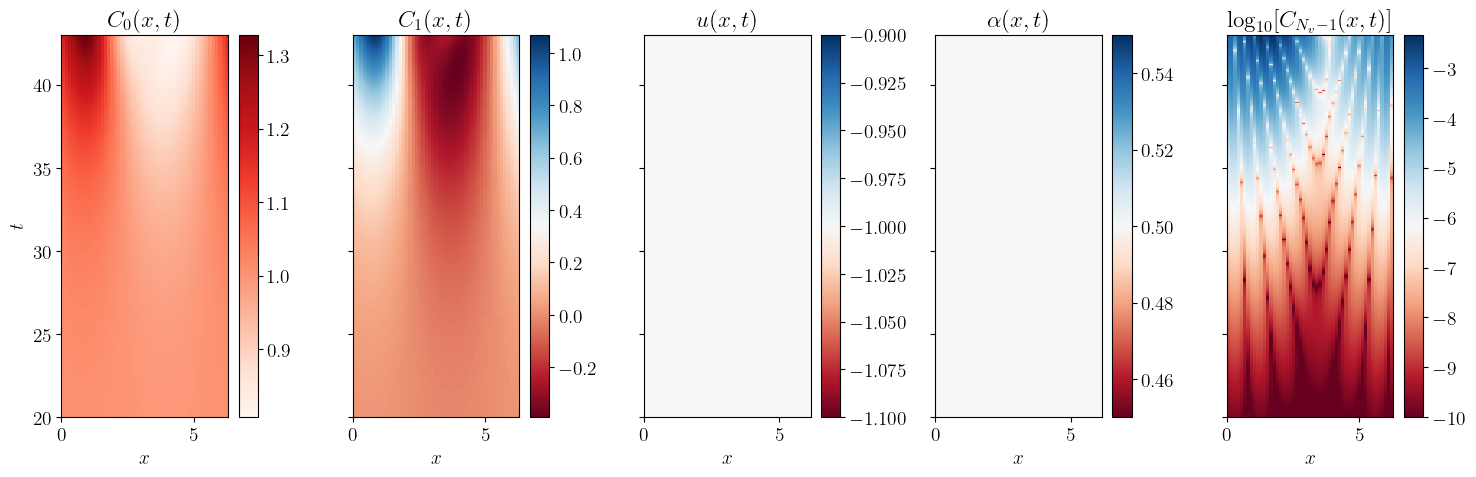

In [14]:
fig, ax = plt.subplots(ncols=5, figsize=(15, 5), sharey=True)
pos = ax[0].pcolormesh(x_, sol_midpoint_t, state_e_H[0, :-1, :-1].T, cmap="Reds")
cbar = fig.colorbar(pos)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$t$")
ax[0].set_title(r"$C_{0}(x, t)$")

pos = ax[1].pcolormesh(x_, sol_midpoint_t, state_e_H[1, :-1, :-1].T, cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[1].set_xlabel(r"$x$")
ax[1].set_title(r"$C_{1}(x, t)$")

pos = ax[2].pcolormesh(x_[:-1], sol_midpoint_t, u_e1[:-1, :-1],  cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[2].set_xlabel(r"$x$")
ax[2].set_title(r"$u(x, t)$")

pos = ax[3].pcolormesh(x_[:-1], sol_midpoint_t, alpha_e1[:-1, :-1],  cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[3].set_xlabel(r"$x$")
ax[3].set_title(r"$\alpha(x, t)$")

pos = ax[4].pcolormesh(x_, sol_midpoint_t, np.log10(np.abs(state_e_H[-1, :-1, :-1])).T, vmin=-10, cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[4].set_xlabel(r"$x$")
ax[4].set_title(r"$\log_{10}[C_{N_{v}-1}(x, t)]$")


for jj in range(5):
    for ii in range(len(change_idxs_u_e1)):
        ax[jj].axhline(sol_midpoint_t[change_idxs_u_e1[ii]+1], color="black", ls="--", linewidth=2)


ax[4].set_ylim(20, sol_midpoint_t[-1])
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/two_stream/two_stream_u_alpha_evolution_e1.png", dpi=600)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_49413/1501963154.py:23: RuntimeWarning: divide by zero encountered in log10
  pos = ax[4].pcolormesh(x_, sol_midpoint_t, np.log10(np.abs(state_e_L[-1, :-1, :-1])).T, vmin=-10, cmap="RdBu", shading='flat')


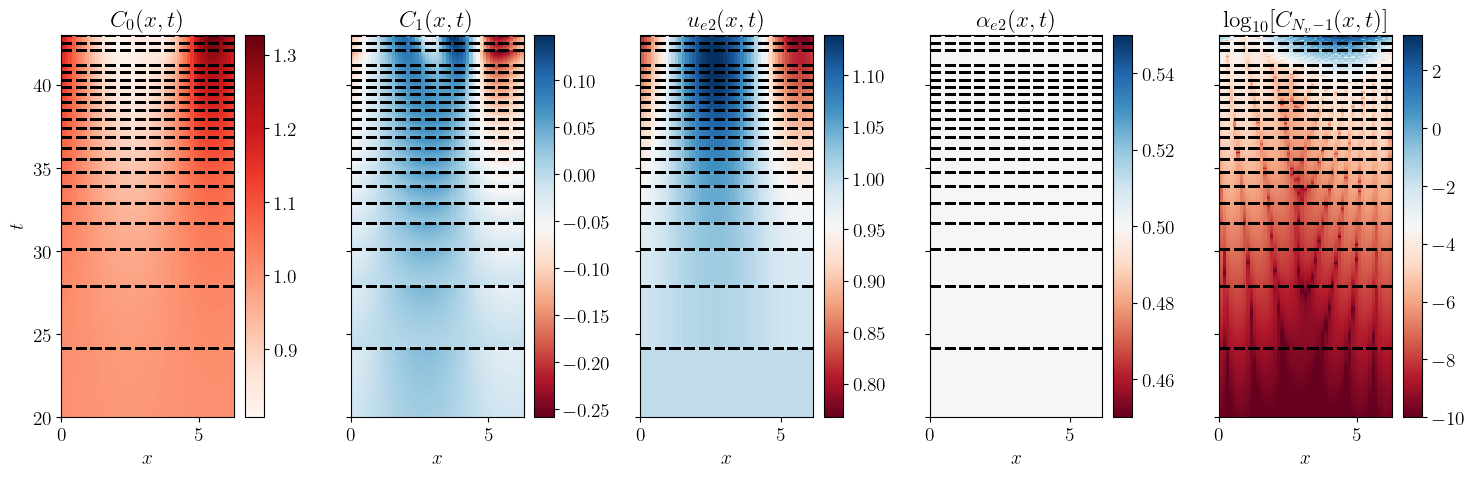

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(15, 5), sharey=True)
pos = ax[0].pcolormesh(x_, sol_midpoint_t, state_e_L[0, :-1, :-1].T, cmap="Reds")
cbar = fig.colorbar(pos)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$t$")
ax[0].set_title(r"$C_{0}(x, t)$")

pos = ax[1].pcolormesh(x_, sol_midpoint_t, state_e_L[1, :-1, :-1].T, cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[1].set_xlabel(r"$x$")
ax[1].set_title(r"$C_{1}(x, t)$")

pos = ax[2].pcolormesh(x_[:-1], sol_midpoint_t, u_e2[:-1, :-1],  cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[2].set_xlabel(r"$x$")
ax[2].set_title(r"$u_{e2}(x, t)$")

pos = ax[3].pcolormesh(x_[:-1], sol_midpoint_t, alpha_e2[:-1, :-1],  cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[3].set_xlabel(r"$x$")
ax[3].set_title(r"$\alpha_{e2}(x, t)$")

pos = ax[4].pcolormesh(x_, sol_midpoint_t, np.log10(np.abs(state_e_L[-1, :-1, :-1])).T, vmin=-10, cmap="RdBu", shading='flat')
cbar = fig.colorbar(pos)
ax[4].set_xlabel(r"$x$")
ax[4].set_title(r"$\log_{10}[C_{N_{v}-1}(x, t)]$")


for jj in range(5):
    for ii in range(len(change_idxs_u_e2)):
        ax[jj].axhline(sol_midpoint_t[change_idxs_u_e2[ii]+1], color="black", ls="--", linewidth=2)


ax[4].set_ylim(20, sol_midpoint_t[-1])
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/two_stream/two_stream_u_alpha_evolution_e2.png", dpi=600)

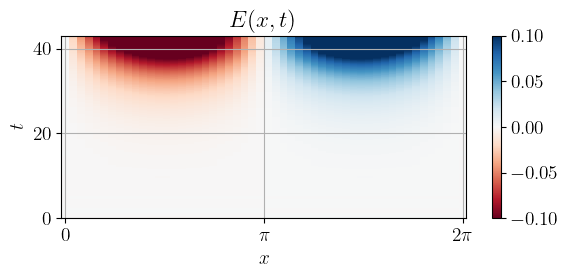

In [16]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(x_, sol_midpoint_t, E_midpoint.T, cmap="RdBu", vmin=-0.1, vmax=0.1)
cbar = fig.colorbar(pos)
plt.grid()
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
#ax.set_ylim(0, 17)
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

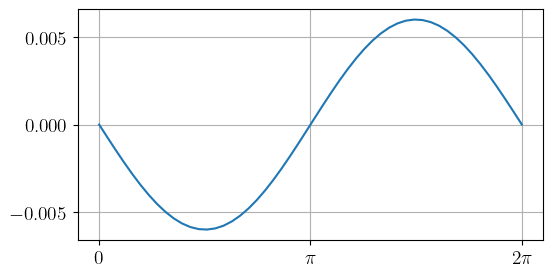

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))

_ = ax.plot(x_, E_midpoint[:,2200])
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.grid()

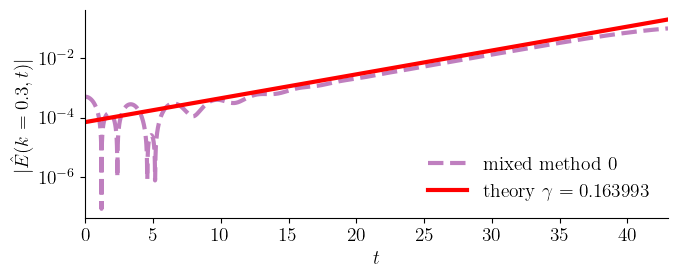

In [18]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint[:-1, :], axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label=r"mixed method 0") 
ax.plot(sol_midpoint_t, 7e-5*np.exp(0.185*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/two_stream/two_stream_growth_rate_legendre.png", dpi=300)

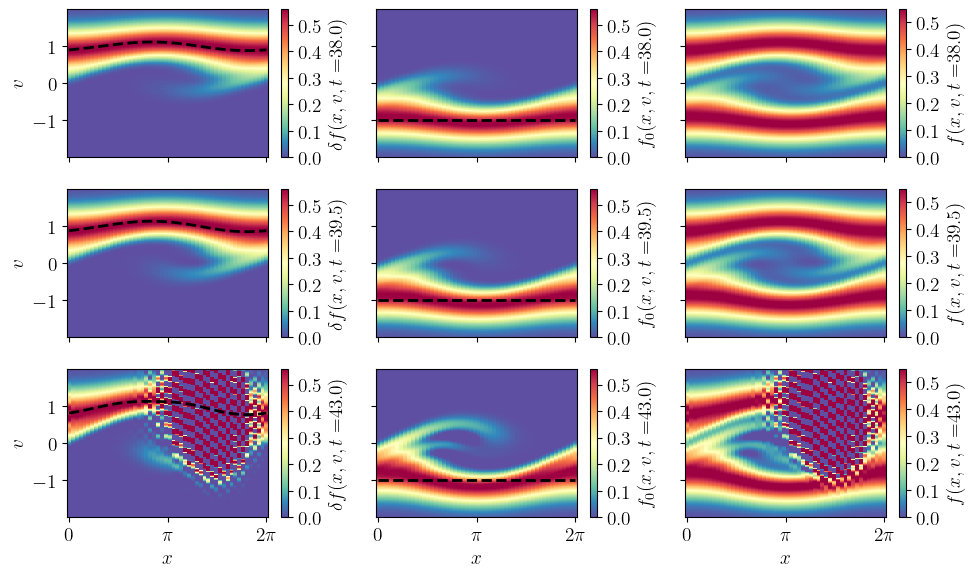

In [19]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 6), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([int(38/setup.dt), int(39.5/setup.dt), -1]):
    ii = int(ii)
    distribution1 = np.zeros((setup.Nx+1, len(v_)))
    distribution2 = np.zeros((setup.Nx+1, len(v_)))
    for jj in range(setup.Nv_e1):
        for kk in range(setup.Nx+1):
            if kk == setup.Nx:
                 distribution1[kk, :] += state_e_H[jj, kk, ii]*aw_psi_hermite(v=v_, u_s=u_e1[ii, 0], alpha_s=alpha_e1[ii, 0], n=jj)
            else:
                distribution1[kk, :] += state_e_H[jj, kk, ii]*aw_psi_hermite(v=v_, u_s=u_e1[ii, kk], alpha_s=alpha_e1[ii, kk], n=jj)
    for jj in range(setup.Nv_e2):
        for kk in range(setup.Nx+1):
            if kk == setup.Nx:
                 distribution2[kk, :] += state_e_L[jj, kk, ii]*aw_psi_hermite(v=v_, u_s=u_e2[ii, 0], alpha_s=alpha_e2[ii, 0], n=jj)
            else:
                distribution2[kk, :] += state_e_L[jj, kk, ii]*aw_psi_hermite(v=v_, u_s=u_e2[ii, kk], alpha_s=alpha_e2[ii, kk], n=jj)
    pos2 = ax[tt, 0].pcolormesh(x_, v_, distribution2.T, cmap="Spectral_r", vmin=0, vmax=0.56)
    pos1 = ax[tt, 1].pcolormesh(x_, v_, distribution1.T, cmap="Spectral_r", vmin=0, vmax=0.56)
    pos3 = ax[tt, 2].pcolormesh(x_, v_, distribution1.T + distribution2.T, cmap="Spectral_r", vmin=0, vmax=0.55)
    
    ax[tt, 1].plot(x_, np.append(u_e1[ii, :] ,u_e1[ii, 0]), color="black", ls="--", linewidth=2)
    ax[tt, 0].plot(x_, np.append(u_e2[ii, :] ,u_e2[ii, 0]), color="black", ls="--", linewidth=2)
    ax[tt, 0].set_yticks([-1, 1, 0])
    ax[tt, 0].set_ylim(-2, 2)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    cbar.ax.set_ylabel('$f_{0}(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

    cbar = fig.colorbar(pos2)
    cbar.ax.set_ylabel('$\delta f(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

    cbar = fig.colorbar(pos3)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, np.pi, 2])
ax[tt, 0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])

ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[tt, 2].set_xlabel("$x$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/two_stream/two_stream_evolution_mixed_method_0_Hermite_Hermite_adapt.png", dpi=600)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_49413/2938835512.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax[0].pcolormesh(np.arange(0, setup.Nv_e1), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_49413/2938835512.py:4: RuntimeWarning: divide by zero encountered in log10
  pos = ax[1].pcolormesh(np.arange(0, setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)


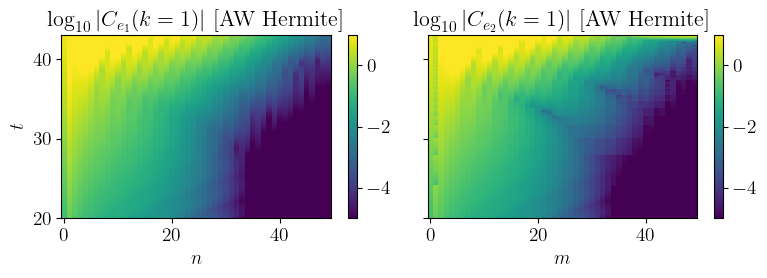

In [20]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(8, 3))
pos = ax[0].pcolormesh(np.arange(0, setup.Nv_e1), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
cbar = fig.colorbar(pos)
pos = ax[1].pcolormesh(np.arange(0, setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
cbar = fig.colorbar(pos)
ax[0].set_xlabel("$n$")
ax[1].set_xlabel("$m$")
ax[0].set_ylabel("$t$")
ax[0].set_title("$\log_{10}|C_{e_{1}}(k=1)|$ [AW Hermite]", fontsize=16)
ax[1].set_title("$\log_{10}|C_{e_{2}}(k=1)|$ [AW Hermite]", fontsize=16)
ax[0].set_ylim(20, 43)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_0/two_stream/spectra_adpative.png", dpi=300)

# conservation laws: mass, momentum, and energy

### mass conservation

In [50]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii, :], dx=setup.dx)\
                        +total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_40275/2888008770.py:3: RuntimeWarning: invalid value encountered in subtract
  ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")


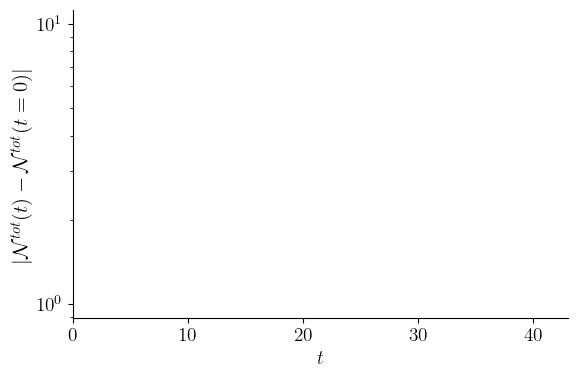

In [51]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [52]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii, :], u_s=u_e1[ii, :],
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_aw_hermite(state=state_e_L[:, :-1, ii], alpha_s=alpha_e2[ii, :], u_s=u_e2[ii, :],
                                                   dx=setup.dx, m_s=setup.m_e)

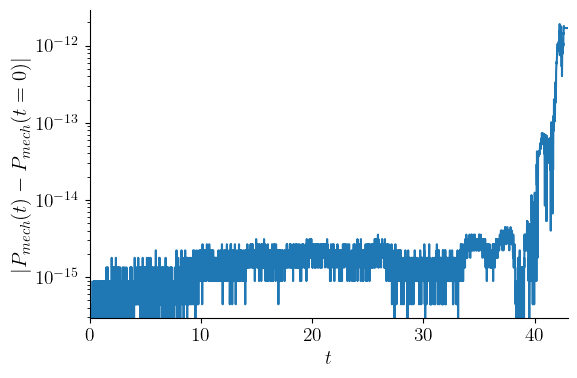

In [53]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [54]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_aw_hermite(state=state_e_H[:, :-1, ii], 
                                                      alpha_s=alpha_e1[ii, :], 
                                                      u_s=u_e1[ii, :], dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

/Users/oissan/PycharmProjects/mixed_methods/operators/legendre/legendre_operators.py:254: RuntimeWarning: invalid value encountered in scalar multiply
  return sigma_v1(n=1, v_a=v_a, v_b=v_b) * sigma_v1(n=2, v_a=v_a, v_b=v_b) * np.sum(state[2, :]) \


In [55]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7f9d666a1280> (for post_execute):


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 600x400 with 1 Axes>

In [ ]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

In [ ]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()